# INGENIERÍA DE DE CARACTERÍSTICAS. FEATURE ENGINEERING


El **objetivo** de este notebook es realizar una ingeniería de características, es decir, trataremos y transformaremos los datos de tal manera que a la hora de modelizar consigamos consigamos mejorar el rendimiento y la precisión de nuestros modelos.

Realizaremos las siguientes tareas:

   - Tratamiento de nulos
   - Manejo de valores extremos
   - Balanceado de datos
   - Creación de variables
   - Divsión del conjunto de datos
   
Al finalizar este proceso, esperamos obtener un conjunto de características que maximice la capacidad predictiva de nuestros modelos, mejore la generalización a nuevos datos y contribuya a la interpretabilidad de los resultados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
import pandas as pd
import numpy as np

# Machine learning kit
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


# Plotting kit
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython import display


# Warning handler

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Combining numerical and categorical piepline into one big pipeline horizontally using ColumnTransformer
from sklearn.compose import ColumnTransformer

## No podemos utilizar TransformTargetRegression porque estamos en un modelo de clasificacion
# from 'Y' and 'N' to numeric values
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [4]:
Base_df = pd.read_csv("../data/base_data02_preprocessing.csv")
if "Unnamed: 0" in Base_df.columns:
    Base_df = Base_df.drop(columns=["Unnamed: 0"])
#Base_df = Base_df.set_index('month')
Base_df_reducido = pd.read_csv("../data/base_reduced_data_preprocessing.csv")

In [5]:
X = Base_df.drop('fraud_bool', axis=1)  
y = Base_df['fraud_bool']

### 1. TRATAMIENTO DE VALORES NULOS

En nuestro dataframe hay 5 vectores con valores nulos los cuales se identifican con valores negativos. Especficamente para las columnas prev_address_months_count, current_address_months_count, bank_months_count y session_length_in_minutes, se representan los valores faltantes con un -1. Para la columna de intended_balcon_amount se representan los valores faltantes con un rango que va desde -16  hasta -1, para poder analizarlos correctamente tratamos estos valores para que sean representados todos con -1. 

In [6]:
filtered_data = Base_df.loc[:]  
# Vectores que serán tratados 
columns_to_replace = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'intended_balcon_amount']

# Remplazamos todos los valores menores que 0 por -1 
filtered_data[columns_to_replace] = filtered_data[columns_to_replace].map(lambda x: -1 if x < 0 else x)

# Calculamos el porcentaje de nulos
null_values = filtered_data[columns_to_replace].map(lambda x: x < 0).sum()
null_percentage = (null_values / len(Base_df)) * 100
base_null_columnas = pd.DataFrame({'nulos_columnas': null_values, 'porcentaje_columnas': null_percentage})
print(base_null_columnas)

                              nulos_columnas  porcentaje_columnas
prev_address_months_count             712920              71.2920
current_address_months_count            4254               0.4254
bank_months_count                     253635              25.3635
session_length_in_minutes               2015               0.2015
intended_balcon_amount                742523              74.2523


Observamos que para las columnas de prev_address_months_count, bank_months_count y intended_balcon_amount hay una cantidad significativa de los valores que son faltantes. Entendemos que es importante mantenerlos como parte del dataset ya que nos pueden brindar información más adelante. Para los vectores de current_address_months_count y session_length_in_minutes estaremos remplazando los valores faltantes con la mediana para rellenar esos valores con una representación robusta de los valores que contienen incluyendo sus outliers. 

In [7]:
# Remplazamos los valores faltantes (-1) por la mediana correspondiente 
columns_to_replace = ['session_length_in_minutes', 'current_address_months_count']

for column in columns_to_replace:
    median_value = Base_df[column][Base_df[column] != -1].median()
    Base_df[column] = np.where(Base_df[column] == -1, median_value, Base_df[column])

print(Base_df)

        fraud_bool  income  name_email_similarity  prev_address_months_count  \
0                1     0.9               0.166828                       -1.0   
1                1     0.9               0.296286                       -1.0   
2                1     0.9               0.044985                       -1.0   
3                1     0.9               0.159511                       -1.0   
4                1     0.9               0.596414                       -1.0   
...            ...     ...                    ...                        ...   
999995           0     0.6               0.192631                       -1.0   
999996           0     0.8               0.322989                      148.0   
999997           0     0.8               0.879403                       -1.0   
999998           0     0.9               0.762112                       -1.0   
999999           0     0.2               0.697452                       -1.0   

        current_address_months_count  c

### 2. TRATAMIENTO DE OUTLIERS

En esta sección estaremos identificando los valores extremos dentro de cada vector y tratandolós según sea necesario. Hemos creado una función que detecta los valores extremos para cada columna usando la fórmula del rango intercuartílico. Esta fórmula cuenta los valores que salen por encima o por debajo del rango definido y calcula el porcentaje de valores extremos que hay en cada vector.

In [8]:
def detect_outliers_iqr(dataframe):
    """
    Detecta valores extremos en un DataFrame de Pandas usando la fórmula del rango intercuatílico (IQR).

    Parameteros:
    - dataframe: Pandas DataFrame

    Devuelve:
    - outlier_info: un DataFrame que contiene la cantidad y porcentaje de valores extremos por vector 
    """

    # Calcula la primera cuartila (Q1)
    q1 = dataframe.quantile(0.25)

    # Calcula la tercera cuartila (Q3)
    q3 = dataframe.quantile(0.75)

    # Calcula el rango intercuartil (IQR)
    iqr = q3 - q1

    # Define los límites superiores e inferiores para detectar los outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Detectamos los valores extremos
    outliers = (dataframe < lower_bound) | (dataframe > upper_bound)

    # Cuenta la cantidad de valores extremos
    num_outliers = outliers.sum()

    # Calcula el porcentaje de valores extremos por vector
    percentage_outliers = (num_outliers / len(dataframe)) * 100

    # Crea un DataFrame para guardar información de los valores extremos 
    outlier_info = pd.DataFrame({
        'num_outliers': num_outliers,
        'porcentage_outliers': percentage_outliers
    })

    return outlier_info


outlier_info = detect_outliers_iqr(Base_df)
print(outlier_info)

                                  num_outliers  porcentage_outliers
fraud_bool                               11029               1.1029
income                                       0               0.0000
name_email_similarity                        0               0.0000
prev_address_months_count               157320              15.7320
current_address_months_count             41493               4.1493
customer_age                              1373               0.1373
days_since_request                       94834               9.4834
intended_balcon_amount                  222702              22.2702
payment_type                                 0               0.0000
zip_count_4w                             59871               5.9871
velocity_6h                               9005               0.9005
velocity_24h                              2917               0.2917
velocity_4w                                  0               0.0000
bank_branch_count_8w                    175243  

Estaremos tratando los valores extremos usando dos técnicas. Para los vectores que tienen un 5% o menos de valores extremos, estaremos remplazando estos valores con la media. Para el resto de vectores estaremos utilizando la técinca de winsorizing ajustando los valores extremos a la percentila 10 y 90; con esta técnica esperamos reducir los valores extremos pero no eliminarlos del todo para mantener una buena representación del dataset. 

### 2.1 Remplazo de valores extremos por la media

Estaremos tratando los valores extremos de los vectores current_address_months_count, customer_age, velocity_6h, velocity_24h, date_of_birth_distinct_emails_4w, credit_risk_score, foreign_request, source y device_distinct_emails_8w

In [9]:
import pandas as pd

columns_to_replace = ['current_address_months_count', 'customer_age', 'velocity_6h', 'velocity_24h', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'foreign_request', 'source', 'device_distinct_emails_8w']

# Función para detectar valores extremos usando la fórmula del rango intercuartil y remplazarlos por la media
def replace_outliers_with_mean(dataframe, columns):
    for column in columns:
        # Calcula la primera cuartila (Q1)
        q1 = dataframe[column].quantile(0.25)

        # Calcula la tercera cuartila (Q3)
        q3 = dataframe[column].quantile(0.75)

        # Calcula el rango intercuartil (IQR)
        iqr = q3 - q1

        # Define los límites superiores e inferiores para detectar los outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    
        # Remplaza los valores extremos por la media del vector 
        dataframe[column] = dataframe[column].apply(lambda x: dataframe[column].mean() if (x < lower_bound or x > upper_bound) else x)

    return dataframe

# Remplaza los valores extremos con la media de cada columna 
Base_df = replace_outliers_with_mean(Base_df, columns_to_replace)

# Imprime el dataframe modificado 
print(Base_df)

        fraud_bool  income  name_email_similarity  prev_address_months_count  \
0                1     0.9               0.166828                       -1.0   
1                1     0.9               0.296286                       -1.0   
2                1     0.9               0.044985                       -1.0   
3                1     0.9               0.159511                       -1.0   
4                1     0.9               0.596414                       -1.0   
...            ...     ...                    ...                        ...   
999995           0     0.6               0.192631                       -1.0   
999996           0     0.8               0.322989                      148.0   
999997           0     0.8               0.879403                       -1.0   
999998           0     0.9               0.762112                       -1.0   
999999           0     0.2               0.697452                       -1.0   

        current_address_months_count  c

### 2.2 Aplicación de la técnica winsorize para valores extremos

Estaremos tratando las columnas prev_address_months_count, days_since_request, intended_balcon_amount, zip_count_4w, bank_branch_count_8w, employment_status, housing_status, phone_mobile_valid, has_other_cards, proposed_credit_limit y session_length_in_minutes de nuestro dataset usando la técnica de winsorize. Estaremos usando un 90% de winsorization para igualar los valores extremos a la quinta y 95 percentila de cada vector que estaremos tratando. Nuestra meta con este tratamiento es conseguir que los valores extremos de estos vectores sean menos extremos sin eliminarlos y evitar una mala representación del dataset.

In [10]:
import pandas as pd

columns_to_replace = ['prev_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'bank_branch_count_8w', 'employment_status', 'housing_status', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'session_length_in_minutes']

# Creamos una función para remplazar los valores extremos por el winsorization de 90%
def replace_outliers_with_winsorization(dataframe, columns):
    for column in columns:
        # Calcula la quinta percentila
        percentila_5 = dataframe[column].quantile(0.05)

        # Calcula la percentila 95
        percentila_95 = dataframe[column].quantile(0.95)

        # Aplica la técnica de winsorization to remplazar los valores extremos
        dataframe[column] = dataframe[column].clip(lower=percentila_5, upper=percentila_95)

    return dataframe

# Remplaza los valores extremos por winsorization de 90%  para los columnas especificadas
Base_df = replace_outliers_with_winsorization(Base_df, columns_to_replace)

#Imprime el dataframe modificado
print(Base_df)

        fraud_bool  income  name_email_similarity  prev_address_months_count  \
0                1     0.9               0.166828                       -1.0   
1                1     0.9               0.296286                       -1.0   
2                1     0.9               0.044985                       -1.0   
3                1     0.9               0.159511                       -1.0   
4                1     0.9               0.596414                       -1.0   
...            ...     ...                    ...                        ...   
999995           0     0.6               0.192631                       -1.0   
999996           0     0.8               0.322989                       98.0   
999997           0     0.8               0.879403                       -1.0   
999998           0     0.9               0.762112                       -1.0   
999999           0     0.2               0.697452                       -1.0   

        current_address_months_count  c

### 3. AGRUPACIÓN Y CREACIÓN DE NUEVAS VARIABLES

In [11]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification

### Agrupación con K-Means

Estaremos usando la técnica del K-Means para encontrar los clusters dentro de nuestros datos. Estaremos usando el Robust Scaler de la librería de scikit learn para mantener nuestros datos dentro de la primera y tercera percentila del rango intercuartil (IQR) y eliminar el ruido causado por los outliers en nuestros datos.

In [12]:
scaler = sklearn.preprocessing.RobustScaler()
model_scaled = scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

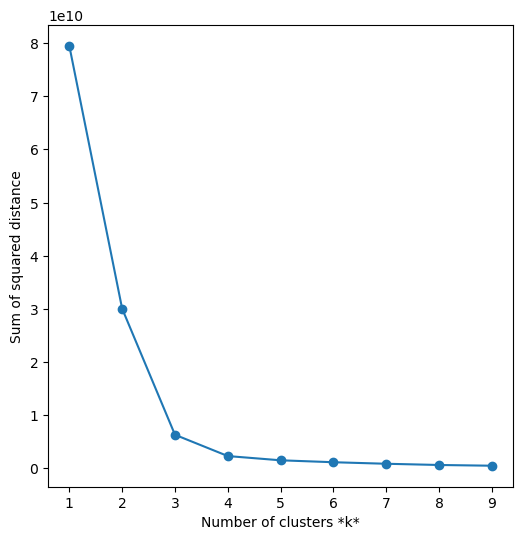

In [13]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Según observamos con el gráfico de codo, se obtuvieron 3 clusters a partir de nuestro dataaset

In [14]:
# call the model and fit it on training data
k_clf = KMeans(n_clusters = 4, random_state = 0)
k_clf.fit(X_scaled)
pd_final_cluster = pd.DataFrame(k_clf.predict(X_scaled), index=X_scaled.index)
pd_final_cluster.columns = ['cluster']
pd_data = pd.concat([pd_final_cluster, Base_df],axis=1)

In [15]:
pd_data['cluster'].value_counts()

cluster
0    945318
3     32925
2     18041
1      3716
Name: count, dtype: int64

In [16]:
pd_data[pd_data['cluster']==1].describe()

,cluster,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,3716.0,3716.000000,3716.000000,3716.000000,3716.000000,3716.000000,3716.000000,3.716000e+03,3716.000000,3716.000000,...,3716.000000,3716.000000,3716.000000,3716.000000,3716.000000,3716.00000,3716.000000,3716.000000,3716.0,3716.000000
mean,1.0,0.012917,0.556028,0.469700,35.932723,36.665123,30.747698,6.682272e+00,3.740384,1.617869,...,0.108181,352.373520,0.000849,0.000099,8.379836,1.38563,0.580194,1.000922,0.0,3.564047
std,0.0,0.112932,0.292368,0.293351,35.248876,54.915717,10.668006,2.762607e-13,12.887689,0.807997,...,0.310650,347.485668,0.004552,0.000828,6.170515,1.21768,0.493593,0.004004,0.0,2.026856
min,1.0,0.000000,0.100000,0.000615,-1.000000,0.000000,10.000000,6.682272e+00,-1.588011,0.000000,...,0.000000,200.000000,0.000000,0.000000,1.274129,0.00000,0.000000,1.000000,0.0,0.000000
25%,1.0,0.000000,0.300000,0.212262,-1.000000,6.000000,20.000000,6.682272e+00,-1.257196,1.000000,...,0.000000,200.000000,0.000000,0.000000,3.649808,0.00000,0.000000,1.000000,0.0,2.000000
50%,1.0,0.000000,0.600000,0.434550,27.000000,12.000000,30.000000,6.682272e+00,-0.947622,2.000000,...,0.000000,200.000000,0.000000,0.000000,6.553055,2.00000,1.000000,1.000000,0.0,4.000000
75%,1.0,0.000000,0.800000,0.724558,57.000000,42.000000,40.000000,6.682272e+00,-0.590096,2.000000,...,0.000000,200.000000,0.000000,0.000000,11.598468,2.00000,1.000000,1.000000,0.0,5.000000
max,1.0,1.000000,0.900000,0.999983,98.000000,295.000000,70.000000,6.682272e+00,50.394003,4.000000,...,1.000000,1500.000000,0.025242,0.007048,21.698864,3.00000,1.000000,1.018312,0.0,7.000000


En este cluster podemos observar los clientes de menor edad dentro del dataset. En este perfil las personas promedian 30 años de edad, 36 meses en su residencia actual, 35 en su residencia anterior y los mayores ingresos anuales de los tres grupos. A diferencia de los otros dos grupos el promedio de tiempo en su residencia actual y la anterior están bastante acercados. También podemos observar dentro de la variable intended_balcon_amount que en promedio hacen menores transferencias de dinero con su aplicación. Dentro de este grupo están las mayores incidencias de fraude de los tres clusters. 

In [17]:
pd_data[pd_data['cluster']==2].describe()

,cluster,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,18041.0,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,1.804100e+04,18041.000000,18041.000000,...,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.0,18041.000000
mean,2.0,0.011363,0.526113,0.469622,25.935536,50.927083,31.023375,6.682272e+00,11.008272,1.163683,...,0.097057,302.959925,0.000595,0.000091,8.606969,1.456848,0.577462,1.000942,0.0,3.154038
std,0.0,0.105993,0.294059,0.284231,33.972264,61.754481,11.291190,2.324427e-12,17.682248,1.012933,...,0.296043,294.376878,0.003828,0.000797,5.993779,1.195443,0.493977,0.004045,0.0,2.136331
min,2.0,0.000000,0.100000,0.000019,-1.000000,0.000000,10.000000,6.682272e+00,-1.588011,0.000000,...,0.000000,200.000000,0.000000,0.000000,1.274129,0.000000,0.000000,1.000000,0.0,0.000000
25%,2.0,0.000000,0.200000,0.214322,-1.000000,9.000000,20.000000,6.682272e+00,-1.060162,0.000000,...,0.000000,200.000000,0.000000,0.000000,4.210647,0.000000,0.000000,1.000000,0.0,1.000000
50%,2.0,0.000000,0.600000,0.457129,11.000000,26.000000,30.000000,6.682272e+00,-0.634219,1.000000,...,0.000000,200.000000,0.000000,0.000000,6.757341,2.000000,1.000000,1.000000,0.0,3.000000
75%,2.0,0.000000,0.800000,0.702671,37.000000,70.000000,40.000000,6.682272e+00,23.282869,2.000000,...,0.000000,200.000000,0.000000,0.000000,11.442205,2.000000,1.000000,1.000000,0.0,5.000000
max,2.0,1.000000,0.900000,0.999993,98.000000,295.000000,70.000000,6.682272e+00,50.394003,4.000000,...,1.000000,1500.000000,0.025242,0.007048,21.698864,3.000000,1.000000,1.018312,0.0,7.000000


En este perfil las personas promedian 31 años de edad, 50 meses en su residencia actual y sus ingresos anuales promedian 0.5, en una escala del [0.1-0.9], es un perfil compuesto de personas con estabilidad económica. Podemos observar dentro de la variable intended_balcon_amount que promedian las mayores transferencias de dinero con su aplicación que los componentes del primer grupo. Dentro de este grupo hay pocas incidencias de fraude. 

In [18]:
pd_data[pd_data['cluster']==3].describe()

,cluster,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,32925.0,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,...,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.000000,32925.0,32925.000000
mean,3.0,0.006682,0.546305,0.508643,24.517267,59.752585,31.799264,6.572283,15.202304,0.841640,...,0.144753,351.507973,0.000547,0.000095,8.560450,1.491450,0.585756,1.000793,0.0,2.620258
std,0.0,0.081470,0.290184,0.290111,34.036189,68.794738,11.535176,0.339605,18.014866,1.004701,...,0.351857,362.524157,0.003677,0.000815,5.939401,1.179787,0.492599,0.003726,0.0,1.927831
min,3.0,0.000000,0.100000,0.000130,-1.000000,0.000000,10.000000,4.648135,-1.588011,0.000000,...,0.000000,200.000000,0.000000,0.000000,1.274129,0.000000,0.000000,1.000000,0.0,0.000000
25%,3.0,0.000000,0.300000,0.249449,-1.000000,10.000000,20.000000,6.682272,-0.954942,0.000000,...,0.000000,200.000000,0.000000,0.000000,4.238490,0.000000,0.000000,1.000000,0.0,1.000000
50%,3.0,0.000000,0.600000,0.500919,8.000000,33.000000,30.000000,6.682272,9.215888,0.000000,...,0.000000,200.000000,0.000000,0.000000,6.755334,2.000000,1.000000,1.000000,0.0,2.000000
75%,3.0,0.000000,0.800000,0.763538,34.000000,86.817583,40.000000,6.682272,29.368817,2.000000,...,0.000000,200.000000,0.000000,0.000000,11.268818,2.000000,1.000000,1.000000,0.0,4.000000
max,3.0,1.000000,0.900000,0.999999,98.000000,295.000000,70.000000,6.682272,50.394003,4.000000,...,1.000000,1500.000000,0.025242,0.007048,21.698864,3.000000,1.000000,1.018312,0.0,7.000000


En este perfil las personas promedian 31 años de edad, 60 meses en su residencia actual, 24 en su residencia anterior y un promedio de ingresos consistente con los demás grupos. Dentro de este grupo se encuentran las menores incidencias de fraude. 

### Creación de variable

Queremos observar el comportamiento del primer cluster ante los distintos modelos predictivos que estaremos tratando. Este cluster lo obtuvimos usando la técnica de k-means e incluye a las personas de perfil conservador en nuestro dataset. Estaremos creando un nuevo vector llamado perimer_cluster dentro de nuestro dataset que indicará si la persona pertenece al primer perfil identificando con un 1 las personas dentro del primer cluster y el resto con un 0. 

In [19]:
#Creamos la columna cluster_classification que identifica a las instancias pertenecientes al primer cluster
pd_data['primer_cluster'] = pd_data['cluster'].apply(lambda x: 1 if x == 1 else 0)

# Concatenamos el vector 'primer_cluster' al dataset original, Base_df
primer_cluster = pd_data['primer_cluster']

Base_df= pd.concat([Base_df, primer_cluster], axis=1)

# Mostramos el nuevo dataset
print(Base_df)

        fraud_bool  income  name_email_similarity  prev_address_months_count  \
0                1     0.9               0.166828                       -1.0   
1                1     0.9               0.296286                       -1.0   
2                1     0.9               0.044985                       -1.0   
3                1     0.9               0.159511                       -1.0   
4                1     0.9               0.596414                       -1.0   
...            ...     ...                    ...                        ...   
999995           0     0.6               0.192631                       -1.0   
999996           0     0.8               0.322989                       98.0   
999997           0     0.8               0.879403                       -1.0   
999998           0     0.9               0.762112                       -1.0   
999999           0     0.2               0.697452                       -1.0   

        current_address_months_count  c

### 4. BALANCEADO DE DATOS: UNDERSAMPLING

**No realizaremos el OneHotEconding ya que en el notebook anterior codificamos las variables categóricas a mano, así que ya tenemos todos nuestros datos en formato numérico**

En la detección de fraudes en aplicaciones de crédito bancarias, a menudo nos enfrentamos a conjuntos de datos altamente desequilibrados, donde la abrumadora mayoría de las transacciones son legítimas y solo un pequeño porcentaje constituye fraudes. 

En nuestro caso, aproximadamente el 99% de las instancias pertenecen a la clase legítima (cero), mientras que solo alrededor del 1% corresponde a fraudes (uno). Esta disparidad en la distribución de clases puede impactar negativamente el rendimiento de los modelos de aprendizaje automático, ya que tienden a sesgarse hacia la clase mayoritaria, minimizando así la atención prestada a los fraudes.

Para abordar este desequilibrio y mejorar la capacidad del modelo para detectar fraudes, hemos optado por **aplicar undersampling** en nuestro conjunto de datos. La estrategia de undersampling implica reducir la cantidad de instancias de la clase mayoritaria para lograr un equilibrio proporcional entre ambas clases.

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

undersample = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersample.fit_resample(X, y)

In [21]:
print(len(X_resampled))
print(len(y_resampled))

22058
22058


### 5. DIVISIÓN DEL CONJUNTO DE ENTRENAMIENTO/PRUEBA/VALIDACIÓN 

Creamos el split de nuestro dataset y luego graficamos para comprobar que esté balanceada nuestra variable target 'fraud_bool'. Es necesario comprobar que esté balanceado nuestro target porque su balance afecta negativamente las predicciones de los modelos. 

In [22]:
X_train0, X_test, y_train0, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)
X_train1, X_val, y_train1, y_val = train_test_split(X_train0, y_train0, test_size=0.5, random_state=1)

print(f"X_train0 shape: {X_train1.shape}, y_train0 shape: {y_train1.shape}")
print(f"X_train1 shape: {X_train1.shape}, y_train1 shape: {y_train1.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train0 shape: (8823, 31), y_train0 shape: (8823,)
X_train1 shape: (8823, 31), y_train1 shape: (8823,)
X_val shape: (8823, 31), y_val shape: (8823,)
X_test shape: (4412, 31), y_test shape: (4412,)


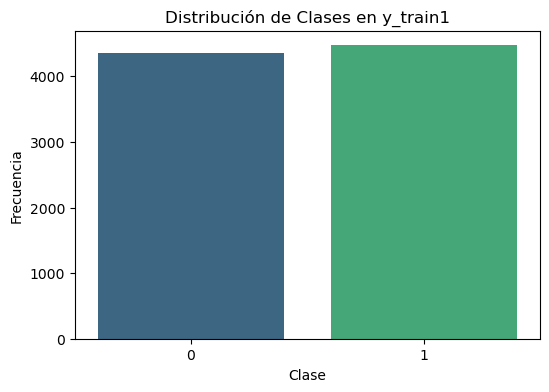

Frecuencia de cada clase:
fraud_bool
1    4472
0    4351
Name: count, dtype: int64


In [23]:
balanced_check_data = pd.concat([X_train1, y_train1], axis=1)

class_counts = balanced_check_data['fraud_bool'].value_counts()
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud_bool', data=balanced_check_data, palette='viridis')
plt.title('Distribución de Clases en y_train1')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

print("Frecuencia de cada clase:")
print(class_counts)

Repetimos los pasos anteriores con el dataset reducido

In [24]:
vars_select = ['fraud_bool', 'income', 'name_email_similarity', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'payment_type', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 'phone_home_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_fraud_count','primer_cluster']
base_reduced = Base_df[vars_select]
base_df_reduced = base_reduced.loc[X_resampled.index]

In [26]:
X_reduced = base_reduced.drop('fraud_bool', axis=1)
y_reduced = base_reduced['fraud_bool']

In [27]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_resampled1, y_resampled1 = undersample.fit_resample(X_reduced, y_reduced)

In [29]:
X_train0_reduced, X_test_reduced, y_train0_reduced, y_test_reduced = train_test_split(
    X_resampled1, y_resampled1, test_size=0.2, random_state=1
)

X_train1_reduced, X_val_reduced, y_train1_reduced, y_val_reduced = train_test_split(
    X_train0_reduced, y_train0_reduced, test_size=0.5, random_state=1
)

print(f"X_train0_reduced shape: {X_train0_reduced.shape}, y_train0_reduced shape: {y_train0_reduced.shape}")
print(f"X_train1_reduced shape: {X_train1_reduced.shape}, y_train1_reduced shape: {y_train1_reduced.shape}")
print(f"X_val_reduced shape: {X_val_reduced.shape}, y_val_reduced shape: {y_val_reduced.shape}")
print(f"X_test_reduced shape: {X_test_reduced.shape}, y_test_reduced shape: {y_test_reduced.shape}")

X_train0_reduced shape: (17646, 22), y_train0_reduced shape: (17646,)
X_train1_reduced shape: (8823, 22), y_train1_reduced shape: (8823,)
X_val_reduced shape: (8823, 22), y_val_reduced shape: (8823,)
X_test_reduced shape: (4412, 22), y_test_reduced shape: (4412,)


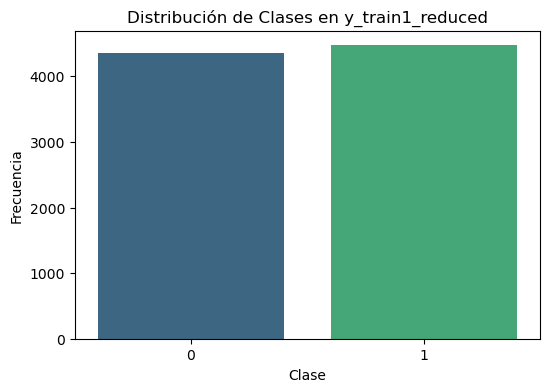

Frecuencia de cada clase:
fraud_bool
1    4472
0    4351
Name: count, dtype: int64


In [30]:
balanced_check_data = pd.concat([X_train1_reduced, y_train1_reduced], axis=1)

class_counts = balanced_check_data['fraud_bool'].value_counts()
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud_bool', data=balanced_check_data, palette='viridis')
plt.title('Distribución de Clases en y_train1_reduced')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

print("Frecuencia de cada clase:")
print(class_counts)

### Guardado de datos en archivos CSV
**Concatenamos datos de entrenamiento, validación y prueba**

In [32]:
train_data0 = pd.concat([X_train0, pd.DataFrame(y_train0, columns=['fraud_bool'])], axis=1)
train_data1 = pd.concat([X_train1, pd.DataFrame(y_train1, columns=['fraud_bool'])], axis=1)
val_data = pd.concat([X_val, pd.DataFrame(y_val, columns=['fraud_bool'])], axis=1)
test_data = pd.concat([X_test, pd.DataFrame(y_test, columns=['fraud_bool'])], axis=1)

train_data0_reduced = pd.concat([X_train0_reduced, pd.DataFrame(y_train0_reduced, columns=['fraud_bool'])], axis=1)
train_data1_reduced = pd.concat([X_train1_reduced, pd.DataFrame(y_train1_reduced, columns=['fraud_bool'])], axis=1)
val_data_reduced = pd.concat([X_val_reduced, pd.DataFrame(y_val_reduced, columns=['fraud_bool'])], axis=1)
test_data_reduced= pd.concat([X_test_reduced, pd.DataFrame(y_test_reduced, columns=['fraud_bool'])], axis=1)

train_data0_reduced.to_csv('../data/train_data0_reduced.csv', index=False)
train_data1_reduced.to_csv('../data/train_data1_reduced.csv', index=False)
val_data_reduced.to_csv('../data/val_data_reduced.csv', index=False)
test_data_reduced.to_csv('../data/test_data_reduced.csv', index=False)

train_data0.to_csv('../data/train_data0.csv', index=False)
train_data1.to_csv('../data/train_data1.csv', index=False)
val_data.to_csv('../data/val_data.csv', index=False)
test_data.to_csv('../data/test_data.csv', index=False)

Base_df.to_csv('../data/data_engineering.csv', index=False)

In [33]:
base_df_reduced.to_csv('../data/reduced_data_engineering.csv', index=False)

### CONCLUSIONES


En primer lugar hemos tratado los datos nulos del dataset. Mantuvimos los nulos de las columnas de prev_address_months_count, bank_months_count y intended_balcon_amount por cantidad significativa de valores faltantes y de esta manera representamos los datos correctamente. Para los vectores de current_address_months_count y session_length_in_minutes remplazamos los valores faltantes con la mediana para rellenar esos valores con una representación robusta de los valores que contienen incluyendo sus outliers.

Luego, tratamos los valores extremos (outliers) de nuestro dataset. Teniendo en cuenta que estos también pueden tener información interesante que nos ayude en las predicciones decidimos tratarlos usando dos técnicas. Para los vectores con menos de un 5% de valores extremos, los remplazamos con la media. Los vectores con más de un 5% de valores extremos los tratamos usando la técnica de "winsorize" para hacerlos menos extremos de modo tal que tengan un mejor desempeño en los modelos pero que no se elimine su presencia y nos brinde información en las predicciones. 

También usamos técnicas de clustering para encontrar grupos dentro de nuestros datos usando K-Means. El algoritmo de K-means creó 3 clusters de los cuales vimos sus características y las describimos. Escogimos el primer cluster creado por K-Means, dónde observamos las incidencias más altas de fraude entre los tres grupos, y la convertimos en una nueva variable en nuestro dataset donde clasificamos con un 1 las instancias que pertenecen a este cluster y con un 0 las que no. Creamos esta variable para observar el comportamiento de este cluster en los modelos de aprendizaje automático.

Como último paso utilizamos la técnica de undersampling para balancear nuestros datos. Tener nuestros datos balanceados ayudará a que los modelos predigan mejor el fraude ya que le proveeremos la misma cantidad de transacciones legítimas que fraudulentas.